# Практическое задание 1
**Поиск решения задачи о компоте с помощью обучения с подкреплением**

Для начала определим исходные данные в задаче.

In [15]:
import random as rnd

GLASSES_COUNT = 5
ORDER = 10
NUM_EPISODES = 20
NUM_ATTEMPTS = pow(ORDER, GLASSES_COUNT)
ALPHA = 0.8  # Коэффициент обучения
GAMMA = 0.95  # Дисконтный фактор
INITIAL_GLASSES = []
Q = {}
for _ in range(GLASSES_COUNT):
    INITIAL_GLASSES.append(rnd.randint(1, ORDER))
if sum(INITIAL_GLASSES) % GLASSES_COUNT != 0:
    INITIAL_GLASSES[GLASSES_COUNT - 1] += GLASSES_COUNT - sum(INITIAL_GLASSES) % GLASSES_COUNT

print("Изначальное состояние стаканов:", INITIAL_GLASSES)

Изначальное состояние стаканов: [6, 10, 3, 4, 7]



Прогоны 1-10: 13667 67532 412242 43 24575 43681 137013 393783 171469 181382 
Прогоны 11-20: 240152 106490 19036 170633 161895 419465 341556 628297 526334 58217 

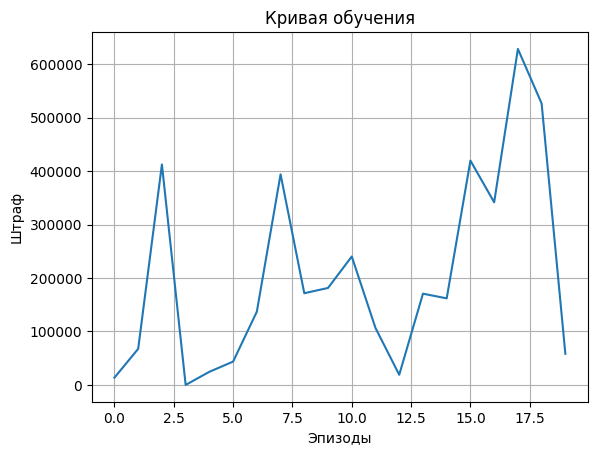

In [ ]:
import matplotlib.pyplot as plt

glasses = INITIAL_GLASSES

def state_to_string(state):
    _t = ""
    for s in state:
        _t += f'-{s}'
    return _t[1:]

def action_to_string(action):
    return f'{action[0]}/{action[1]}/{action[2]}'

def describe_action(action):
    return f'Агент переливает {action[2]} мл. компота из стакана № {action[0]+1} в стакан № {action[1]+1}'

def is_equal(glasses):
    for i in range(len(glasses)-1):
        if glasses[i] != glasses[i+1]:
            return False
    return True

def choose_random_action():
    glass_from = rnd.randint(0, GLASSES_COUNT-1)
    if INITIAL_GLASSES[glass_from] == 0:
        return choose_random_action()
    glass_to = rnd.randint(0, GLASSES_COUNT-2)
    if glass_to >= glass_from:
        glass_to += 1
    glass_compote = rnd.randint(1, INITIAL_GLASSES[glass_from])
    return (glass_from, glass_to, glass_compote)

def pour_compote(glasses, instruction):
    if glasses[instruction[0]] >= instruction[2]:
        glasses[instruction[0]] -= instruction[2]
        glasses[instruction[1]] += instruction[2]
    # else:
    #     glasses[instruction[1]] += glasses[instruction[0]]
    #     glasses[instruction[0]] = 0
    return glasses

def get_all_actions(glasses):
    actions = []
    for i in range(0, len(glasses)):
        for j in range(0, len(glasses)):
            if i == j:
                continue
            for k in range(1, glasses[i]+1):
                actions.append(action_to_string((i, j, k)))
    return actions

#ALL_ACTIONS = get_all_actions(INITIAL_GLASSES)

def choose_action(state):
    if state not in Q:
        return choose_random_action()
    
    max_value = max(Q[state].values())
    best_actions = [action for action, value in Q[state].items() if value == max_value]
    choice = rnd.choice(best_actions)
    return (int(choice.split("/")[0]), int(choice.split("/")[1]), int(choice.split("/")[2]))

def update_Q(state, action, reward, next_state):
    if state not in Q:
        Q[state] = {}
        for a in get_all_actions(state):
            Q[state][a] = 0
    
    # Q[state][action_to_string(action)] = Q[state][action_to_string(action)] + ALPHA * (reward + GAMMA * max([Q[state].values()]) - Q[state][action_to_string(action)])
    Q[state][action] = Q[state][action] + ALPHA * (reward + GAMMA * max(Q[next_state].values()) - Q[state][action])

rewards_history = []
for ep in range(NUM_EPISODES):
    glasses = INITIAL_GLASSES.copy()
    # for at in range(NUM_ATTEMPTS):
    at = 0
    while not is_equal(glasses):
        at += 1
        #print("Состояние стаканов:", glasses)
        if is_equal(glasses):
            print(f"Прогон {ep}: стаканы уравновешены c {at}-й попытки")
            rewards_history.append(at)
            break
        action = choose_action(state_to_string(glasses))
        #print(describe_action(action))
        new_glasses = pour_compote(glasses, action)
        update_Q(state_to_string(glasses), action_to_string(action), -1, state_to_string(new_glasses))
        glasses = new_glasses.copy()
    #print(f"На {ep}-м прогоне агент не смог уравновесить стаканы")
    if ep % 10 == 0:
        print(f"\nПрогоны {ep+1}-{ep+10}: {at} ", end="")
    else:
        print(f"{at}", end=" ")
    rewards_history.append(at)

plt.plot(rewards_history)
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()

In [21]:
for i in range(1, 2):
    print(i)

1


In [ ]:
import json

with open("Q.txt", 'w') as file:
    json.dump(Q, file)

with open("rewards_history.txt", 'w') as file:
    json.dump(rewards_history, file)

In [1]:
import numpy as np
from collections import defaultdict
import random

class CompotEqualizer:
    def __init__(self, glasses):
        self.glasses = glasses
        self.n_glasses = len(glasses)
        self.total_compot = sum(self.glasses)
        
        # Количество шагов до остановки
        self.max_steps = 1000
        
        # Параметры обучения
        self.alpha = 0.8   # Скорость обучения
        self.gamma = 0.9   # Коэффициент дисконтирования
        self.epsilon = 0.05  # Вероятность случайных действий
        
        # Q-значения
        self.Q = defaultdict(lambda: defaultdict(float))
    
    def _get_actions(self, state):
        actions = []
        for i in range(self.n_glasses):
            for j in range(self.n_glasses):
                if i != j:
                    min_transfer = min(state[i], self.total_compot // self.n_glasses - state[j])
                    if min_transfer > 0:
                        actions.append((i, j, min_transfer))
        return actions
    
    def _reward(self, new_state):
        target_level = self.total_compot / self.n_glasses
        reward = -sum([abs(x - target_level) for x in new_state]) / self.total_compot
        return reward
    
    def _update_Q(self, state, action, next_state, reward):
        current_q_value = self.Q[state][action]
        max_next_q_value = max(self.Q[next_state].values(), default=0)
        new_q_value = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_next_q_value)
        self.Q[state][action] = new_q_value
    
    def train(self, episodes=5000):
        for episode in range(episodes):
            state = tuple(self.glasses)
            
            steps = 0
            while steps < self.max_steps:
                actions = self._get_actions(state)
                
                if random.random() < self.epsilon:
                    action = random.choice(actions)
                else:
                    q_values = {a: self.Q[state][a] for a in actions}
                    best_action = max(q_values, key=q_values.get)
                    action = best_action
                    
                next_state = list(state)
                next_state[action[1]] += action[2]
                next_state[action[0]] -= action[2]
                next_state = tuple(next_state)
                
                reward = self._reward(next_state)
                
                self._update_Q(state, action, next_state, reward)
                
                state = next_state
                steps += 1
                
                if all([x == self.total_compot // self.n_glasses for x in state]):
                    break
    
    def solve(self):
        state = tuple(self.glasses)
        steps = 0
        while steps < self.max_steps:
            actions = self._get_actions(state)
            q_values = {a: self.Q[state][a] for a in actions}
            best_action = max(q_values, key=q_values.get)
            print(f"Шаг {steps}: Переливаем {best_action[2]} мл из стакана {best_action[0]+1} в стакан {best_action[1]+1}")
            
            next_state = list(state)
            next_state[best_action[1]] += best_action[2]
            next_state[best_action[0]] -= best_action[2]
            next_state = tuple(next_state)
            
            state = next_state
            steps += 1
            
            if all([x == self.total_compot // self.n_glasses for x in state]):
                print("Компоты уравнены!")
                break
        print(f"Конечное состояние стаканов: {state}")

In [2]:
initial_glasses = [50, 150, 200, 300, 400]

equalizer = CompotEqualizer(initial_glasses)
equalizer.train()
equalizer.solve()

Шаг 0: Переливаем 170 мл из стакана 5 в стакан 1
Шаг 1: Переливаем 70 мл из стакана 4 в стакан 2
Шаг 2: Переливаем 20 мл из стакана 4 в стакан 3
Шаг 3: Переливаем 10 мл из стакана 5 в стакан 4
Компоты уравнены!
Конечное состояние стаканов: (220, 220, 220, 220, 220)


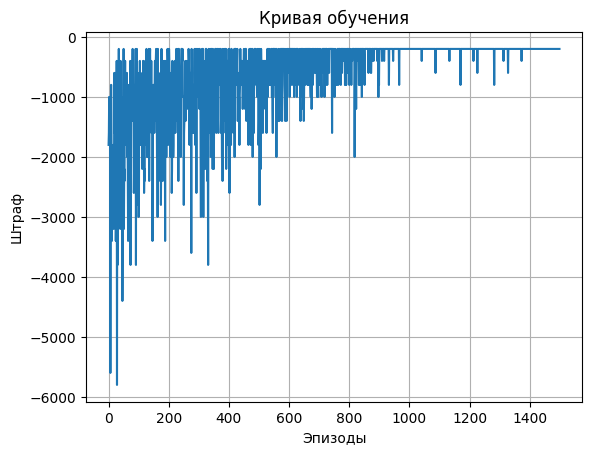

Шаг 0: Переливаем из стакана 4 в стакан 0
Шаг 1: Переливаем из стакана 3 в стакан 1

Равномерное распределение достигнуто за 2 шагов.


In [7]:
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Начальные объемы компотов в стаканах
initial_glasses = [100, 200, 300, 400, 500]
target_volume = sum(initial_glasses) // len(initial_glasses)  # Целевой объем в каждом стакане

# Параметры обучения
num_episodes = 1500
alpha = 0.8  # Коэффициент обучения
gamma = 0.95  # Дисконтный фактор
epsilon = 1.0  # Вероятность случайных действий (начальная)
min_epsilon = 0.01  # Минимальная вероятность случайных действий
epsilon_decay_rate = 0.001  # Скорость уменьшения epsilon

# Функция для генерации возможных действий (переливание из одного стакана в другой)
def get_actions(state):
    actions = []
    for i in range(len(state)):
        for j in range(len(state)):
            if i != j and state[i] > target_volume:
                actions.append((i, j))
    return actions

# Функция для выполнения действия (перелива)
def take_action(state, action):
    new_state = list(state)
    glass_from, glass_to = action
    
    transfer_amount = min(new_state[glass_from] - target_volume, target_volume - new_state[glass_to])
    new_state[glass_from] -= transfer_amount
    new_state[glass_to] += transfer_amount
    
    return tuple(new_state)

# Функция вознаграждения (штрафа)
def reward_function(state):
    total_deviation = sum(abs(volume - target_volume) for volume in state)
    return -total_deviation

# Инициализация Q-таблицы
Q = defaultdict(lambda: defaultdict(int))  # Q(s, a)

# Обучение
rewards_history = []  # Для хранения истории вознаграждений

for episode in range(num_episodes):
    current_state = tuple(initial_glasses)
    done = False
    total_reward = 0
    
    while not done:
        possible_actions = get_actions(current_state)
        
        # Выбор действия: либо случайно, либо согласно политике
        if random.uniform(0, 1) < epsilon:
            action = random.choice(possible_actions)
        else:
            q_values = {action: Q[current_state][action] for action in possible_actions}
            max_q_value = max(q_values.values())
            best_actions = [a for a in possible_actions if q_values[a] == max_q_value]
            action = random.choice(best_actions)
        
        next_state = take_action(current_state, action)
        reward = reward_function(next_state)
        
        # Обновление Q-таблицы
        best_next_action = max(Q[next_state].values(), default=0)
        Q[current_state][action] += alpha * (reward + gamma * best_next_action - Q[current_state][action])
        
        current_state = next_state
        total_reward += reward
        
        if all(volume == target_volume for volume in current_state):
            done = True
            
    rewards_history.append(total_reward)
    
    # Уменьшение epsilon
    epsilon = max(min_epsilon, epsilon - epsilon_decay_rate)

# Вывод кривой обучения
plt.plot(rewards_history)
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()

# Действие обученного агента
current_state = tuple(initial_glasses)
done = False
steps = 0

while not done:
    possible_actions = get_actions(current_state)
    
    q_values = {action: Q[current_state][action] for action in possible_actions}
    max_q_value = max(q_values.values())
    best_actions = [a for a in possible_actions if q_values[a] == max_q_value]
    action = random.choice(best_actions)
    
    print(f'Шаг {steps}: Переливаем из стакана {action[0]} в стакан {action[1]}')
    
    next_state = take_action(current_state, action)
    current_state = next_state
    steps += 1
    
    if all(volume == target_volume for volume in current_state):
        done = True

print(f'\nРавномерное распределение достигнуто за {steps} шагов.')


Этап обучения: 0
Исходное состояние: [50, 200, 300, 400, 550]
Шаг 0: Переливаем -250 мл из стакана 3 в стакан 4
Текущее состояние: [50, 200, 300, 650, 300]
Шаг 1: Переливаем 250 мл из стакана 3 в стакан 0
Текущее состояние: [300, 200, 300, 400, 300]
Шаг 2: Переливаем 0 мл из стакана 3 в стакан 0
Текущее состояние: [300, 200, 300, 400, 300]
Шаг 3: Переливаем 0 мл из стакана 3 в стакан 4
Текущее состояние: [300, 200, 300, 400, 300]
Шаг 4: Переливаем 0 мл из стакана 3 в стакан 2
Текущее состояние: [300, 200, 300, 400, 300]
Шаг 5: Переливаем 0 мл из стакана 3 в стакан 4
Текущее состояние: [300, 200, 300, 400, 300]
Шаг 6: Переливаем 0 мл из стакана 3 в стакан 2
Текущее состояние: [300, 200, 300, 400, 300]
Шаг 7: Переливаем 100 мл из стакана 3 в стакан 1
Текущее состояние: [300, 300, 300, 300, 300]
Равномерное распределение достигнуто за 8 шагов.

Этап обучения: 6
Исходное состояние: [50, 200, 300, 400, 550]
Шаг 0: Переливаем -100 мл из стакана 4 в стакан 3
Текущее состояние: [50, 200, 300,

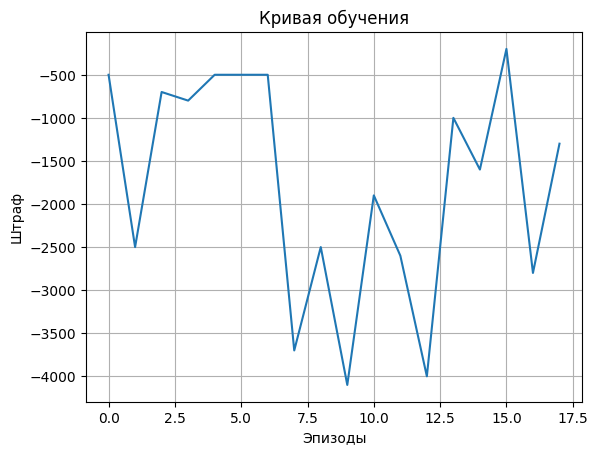

In [13]:
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Начальные объемы компотов в стаканах
initial_glasses = [50, 200, 300, 400, 550]
target_volume = sum(initial_glasses) // len(initial_glasses)  # Целевой объем в каждом стакане

# Параметры обучения
num_episodes = 18
alpha = 0.8  # Коэффициент обучения
gamma = 0.95  # Дисконтный фактор
epsilon = 1.0  # Вероятность случайных действий (начальная)
min_epsilon = 0.01  # Минимальная вероятность случайных действий
epsilon_decay_rate = 0.001  # Скорость уменьшения epsilon

# Функция для генерации возможных действий (переливание из одного стакана в другой)
def get_actions(state):
    actions = []
    for i in range(len(state)):
        for j in range(len(state)):
            if i != j and state[i] > target_volume:
                actions.append((i, j))
    return actions

# Функция для выполнения действия (перелива)
def take_action(state, action):
    new_state = list(state)
    glass_from, glass_to = action
    
    transfer_amount = min(new_state[glass_from] - target_volume, target_volume - new_state[glass_to])
    new_state[glass_from] -= transfer_amount
    new_state[glass_to] += transfer_amount
    
    return tuple(new_state), transfer_amount

# Функция вознаграждения (штрафа)
def reward_function(state):
    total_deviation = sum(abs(volume - target_volume) for volume in state)
    return -total_deviation

# Инициализация Q-таблицы
Q = defaultdict(lambda: defaultdict(int))  # Q(s, a)

# Обучение
rewards_history = []  # Для хранения истории вознаграждений

for episode in range(num_episodes):
    current_state = tuple(initial_glasses)
    done = False
    total_reward = 0
    
    while not done:
        possible_actions = get_actions(current_state)
        
        # Выбор действия: либо случайно, либо согласно политике
        if random.uniform(0, 1) < epsilon:
            action = random.choice(possible_actions)
        else:
            q_values = {action: Q[current_state][action] for action in possible_actions}
            max_q_value = max(q_values.values())
            best_actions = [a for a in possible_actions if q_values[a] == max_q_value]
            action = random.choice(best_actions)
        
        next_state, transfer_amount = take_action(current_state, action)
        reward = reward_function(next_state)
        
        # Обновление Q-таблицы
        best_next_action = max(Q[next_state].values(), default=0)
        Q[current_state][action] += alpha * (reward + gamma * best_next_action - Q[current_state][action])
        
        current_state = next_state
        total_reward += reward
        
        if all(volume == target_volume for volume in current_state):
            done = True
            
    rewards_history.append(total_reward)
    
    # Уменьшение epsilon
    epsilon = max(min_epsilon, epsilon - epsilon_decay_rate)

    # Показываем действия агента на разных этапах обучения
    if episode == 0 or episode == num_episodes // 3 or episode == 2 * num_episodes // 3 or episode == num_episodes - 1:
        print(f"\nЭтап обучения: {episode}")
        print("Исходное состояние:", initial_glasses)
        current_state = tuple(initial_glasses)
        done = False
        step_count = 0
        
        while not done:
            possible_actions = get_actions(current_state)
            q_values = {action: Q[current_state][action] for action in possible_actions}
            max_q_value = max(q_values.values())
            best_actions = [a for a in possible_actions if q_values[a] == max_q_value]
            action = random.choice(best_actions)
            
            next_state, transfer_amount = take_action(current_state, action)
            print(f"Шаг {step_count}: Переливаем {transfer_amount} мл из стакана {action[0]} в стакан {action[1]}")
            print("Текущее состояние:", list(next_state))
            
            current_state = next_state
            step_count += 1
            
            if all(volume == target_volume for volume in current_state):
                done = True
                
        print(f"Равномерное распределение достигнуто за {step_count} шагов.")

# Вывод кривой обучения
plt.plot(rewards_history)
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()


Этап обучения: 0
Исходное состояние: [51, 402, 300, 156, 591]
Шаг 0: Переливаем 0 мл из стакана 4 в стакан 2
Текущее состояние: [51, 402, 300, 156, 591]
Шаг 1: Переливаем 249 мл из стакана 4 в стакан 0
Текущее состояние: [300, 402, 300, 156, 342]
Шаг 2: Переливаем -42 мл из стакана 1 в стакан 4
Текущее состояние: [300, 444, 300, 156, 300]
Шаг 3: Переливаем 0 мл из стакана 1 в стакан 0
Текущее состояние: [300, 444, 300, 156, 300]
Шаг 4: Переливаем 0 мл из стакана 1 в стакан 0
Текущее состояние: [300, 444, 300, 156, 300]
Шаг 5: Переливаем 0 мл из стакана 1 в стакан 0
Текущее состояние: [300, 444, 300, 156, 300]
Шаг 6: Переливаем 0 мл из стакана 1 в стакан 2
Текущее состояние: [300, 444, 300, 156, 300]
Шаг 7: Переливаем 0 мл из стакана 1 в стакан 2
Текущее состояние: [300, 444, 300, 156, 300]
Шаг 8: Переливаем 144 мл из стакана 1 в стакан 3
Текущее состояние: [300, 300, 300, 300, 300]
Равномерное распределение достигнуто за 9 шагов.

Этап обучения: 2
Исходное состояние: [51, 402, 300, 15

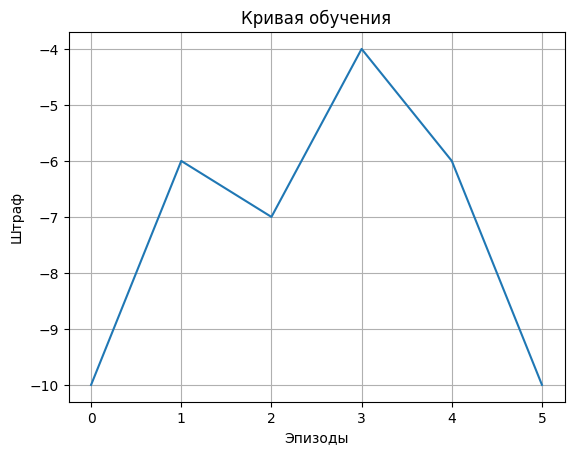

In [16]:
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Начальные объемы компота в стаканах
initial_glasses = [51, 402, 300, 156, 591]
target_volume = sum(initial_glasses) // len(initial_glasses)  # Целевой объем в каждом стакане

# Параметры обучения
num_episodes = 6
alpha = 0.8  # Коэффициент обучения
gamma = 0.95  # Дисконтный фактор
epsilon = 1.0  # Вероятность случайных действий (начальная)
min_epsilon = 0.01  # Минимальная вероятность случайных действий
epsilon_decay_rate = 0.001  # Скорость уменьшения epsilon

# Функция для генерации возможных действий (переливание из одного стакана в другой)
def get_actions(state):
    actions = []
    for i in range(len(state)):
        for j in range(len(state)):
            if i != j and state[i] > target_volume:
                actions.append((i, j))
    return actions

# Функция для выполнения действия (перелива)
def take_action(state, action):
    new_state = list(state)
    glass_from, glass_to = action
    
    transfer_amount = min(new_state[glass_from] - target_volume, target_volume - new_state[glass_to])
    new_state[glass_from] -= transfer_amount
    new_state[glass_to] += transfer_amount
    
    return tuple(new_state), transfer_amount

# Функция штрафа (фиксированная стоимость действия)
def penalty():
    return -1

# Инициализация Q-таблицы
Q = defaultdict(lambda: defaultdict(int))  # Q(s, a)

# Обучение
rewards_history = []  # Для хранения истории штрафов

for episode in range(num_episodes):
    current_state = tuple(initial_glasses)
    done = False
    total_penalty = 0
    
    while not done:
        possible_actions = get_actions(current_state)
        
        # Выбор действия: либо случайно, либо согласно политике
        if random.uniform(0, 1) < epsilon:
            action = random.choice(possible_actions)
        else:
            q_values = {action: Q[current_state][action] for action in possible_actions}
            max_q_value = max(q_values.values())
            best_actions = [a for a in possible_actions if q_values[a] == max_q_value]
            action = random.choice(best_actions)
        
        next_state, transfer_amount = take_action(current_state, action)
        p = penalty()  # Фиксированный штраф за любое действие
        
        # Обновление Q-таблицы
        best_next_action = max(Q[next_state].values(), default=0)
        Q[current_state][action] += alpha * (p + gamma * best_next_action - Q[current_state][action])
        
        current_state = next_state
        total_penalty += p
        
        if all(volume == target_volume for volume in current_state):
            done = True
            
    rewards_history.append(total_penalty)
    
    # Уменьшение epsilon
    epsilon = max(min_epsilon, epsilon - epsilon_decay_rate)

    # Показываем действия агента на разных этапах обучения
    if episode == 0 or episode == num_episodes // 3 or episode == 2 * num_episodes // 3 or episode == num_episodes - 1:
        print(f"\nЭтап обучения: {episode}")
        print("Исходное состояние:", initial_glasses)
        current_state = tuple(initial_glasses)
        done = False
        step_count = 0
        
        while not done:
            possible_actions = get_actions(current_state)
            q_values = {action: Q[current_state][action] for action in possible_actions}
            max_q_value = max(q_values.values())
            best_actions = [a for a in possible_actions if q_values[a] == max_q_value]
            action = random.choice(best_actions)
            
            next_state, transfer_amount = take_action(current_state, action)
            print(f"Шаг {step_count}: Переливаем {transfer_amount} мл из стакана {action[0]} в стакан {action[1]}")
            print("Текущее состояние:", list(next_state))
            
            current_state = next_state
            step_count += 1
            
            if all(volume == target_volume for volume in current_state):
                done = True
                
        print(f"Равномерное распределение достигнуто за {step_count} шагов.")

# Вывод кривой обучения
plt.plot(rewards_history)
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()


Этап обучения: 0
Исходное состояние: [51, 402, 300, 156, 591]
Шаг 0: Переливаем 0 мл из стакана 4 в стакан 2
Текущее состояние: [51, 402, 300, 156, 591]
Шаг 1: Переливаем 102 мл из стакана 1 в стакан 3
Текущее состояние: [51, 300, 300, 258, 591]
Шаг 2: Переливаем 0 мл из стакана 4 в стакан 2
Текущее состояние: [51, 300, 300, 258, 591]
Шаг 3: Переливаем 0 мл из стакана 4 в стакан 2
Текущее состояние: [51, 300, 300, 258, 591]
Шаг 4: Переливаем 0 мл из стакана 4 в стакан 1
Текущее состояние: [51, 300, 300, 258, 591]
Шаг 5: Переливаем 0 мл из стакана 4 в стакан 1
Текущее состояние: [51, 300, 300, 258, 591]
Шаг 6: Переливаем 249 мл из стакана 4 в стакан 0
Текущее состояние: [300, 300, 300, 258, 342]
Шаг 7: Переливаем 0 мл из стакана 4 в стакан 1
Текущее состояние: [300, 300, 300, 258, 342]
Шаг 8: Переливаем 0 мл из стакана 4 в стакан 2
Текущее состояние: [300, 300, 300, 258, 342]
Шаг 9: Переливаем 0 мл из стакана 4 в стакан 1
Текущее состояние: [300, 300, 300, 258, 342]
Шаг 10: Переливаем 

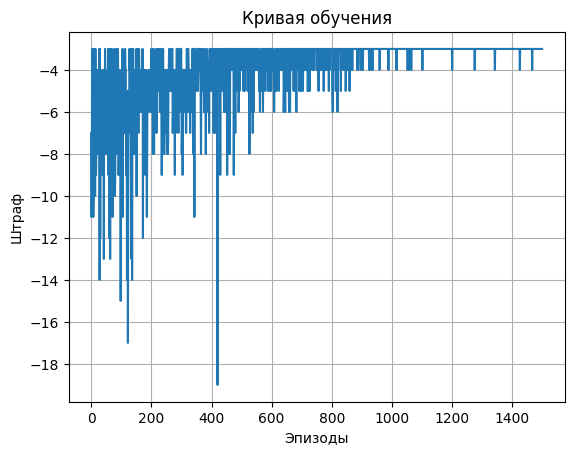

In [ ]:
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Начальные объемы компотов в стаканах
initial_glasses = [51, 402, 300, 156, 591]
target_volume = sum(initial_glasses) // len(initial_glasses)  # Целевой объем в каждом стакане

# Параметры обучения
num_episodes = 8
alpha = 0.8  # Коэффициент обучения
gamma = 0.95  # Дисконтный фактор
epsilon = 1.0  # Вероятность случайных действий (начальная)
min_epsilon = 0.01  # Минимальная вероятность случайных действий
epsilon_decay_rate = 0.001  # Скорость уменьшения epsilon

# Функция для генерации возможных действий (переливание из одного стакана в другой)
def get_actions(state):
    actions = []
    for i in range(len(state)):
        for j in range(len(state)):
            if i != j and state[i] > target_volume:
                actions.append((i, j))
    return actions

# Функция для выполнения действия (перелива)
def take_action(state, action):
    new_state = list(state)
    glass_from, glass_to = action
    
    transfer_amount = min(new_state[glass_from] - target_volume, target_volume - new_state[glass_to])
    new_state[glass_from] -= transfer_amount
    new_state[glass_to] += transfer_amount
    
    return tuple(new_state), transfer_amount

# Функция штрафа (фиксированная стоимость действия)
def penalty():
    return -1

# Инициализация Q-таблицы
Q = defaultdict(lambda: defaultdict(int))  # Q(s, a)

# Обучение
rewards_history = []  # Для хранения истории штрафов

for episode in range(num_episodes):
    current_state = tuple(initial_glasses)
    done = False
    total_penalty = 0
    
    while not done:
        possible_actions = get_actions(current_state)
        
        # Выбор действия: либо случайно, либо согласно политике
        if random.uniform(0, 1) < epsilon:
            action = random.choice(possible_actions)
        else:
            q_values = {action: Q[current_state][action] for action in possible_actions}
            max_q_value = max(q_values.values())
            best_actions = [a for a in possible_actions if q_values[a] == max_q_value]
            action = random.choice(best_actions)
        
        next_state, transfer_amount = take_action(current_state, action)
        p = penalty()  # Фиксированный штраф за любое действие
        
        # Обновление Q-таблицы
        best_next_action = max(Q[next_state].values(), default=0)
        Q[current_state][action] += alpha * (p + gamma * best_next_action - Q[current_state][action])
        
        current_state = next_state
        total_penalty += p
        
        if all(volume == target_volume for volume in current_state):
            done = True
            
    rewards_history.append(total_penalty)
    
    # Уменьшение epsilon
    epsilon = max(min_epsilon, epsilon - epsilon_decay_rate)

    # Показываем действия агента на разных этапах обучения
    if episode == 0 or episode == num_episodes // 3 or episode == 2 * num_episodes // 3 or episode == num_episodes - 1:
        print(f"\nЭтап обучения: {episode}")
        print("Исходное состояние:", initial_glasses)
        current_state = tuple(initial_glasses)
        done = False
        step_count = 0
        
        while not done:
            possible_actions = get_actions(current_state)
            q_values = {action: Q[current_state][action] for action in possible_actions}
            max_q_value = max(q_values.values())
            best_actions = [a for a in possible_actions if q_values[a] == max_q_value]
            action = random.choice(best_actions)
            
            next_state, transfer_amount = take_action(current_state, action)
            print(f"Шаг {step_count}: Переливаем {transfer_amount} мл из стакана {action[0]} в стакан {action[1]}")
            print("Текущее состояние:", list(next_state))
            
            current_state = next_state
            step_count += 1
            
            if all(volume == target_volume for volume in current_state):
                done = True
                
        print(f"Равномерное распределение достигнуто за {step_count} шагов.")

# Вывод кривой обучения
plt.plot(rewards_history)
plt.xlabel('Эпизоды')
plt.ylabel('Штраф')
plt.title('Кривая обучения')
plt.grid(True)
plt.show()